<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/master/C3/W3/ungraded_labs/C3_W3_Lab_4_imdb_reviews_with_GRU_LSTM_Conv1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Building Models for the IMDB Reviews Dataset

In this lab, you will build four models and train it on the [IMDB Reviews dataset](https://www.tensorflow.org/datasets/catalog/imdb_reviews) with full word encoding. These use different layers after the embedding namely `Flatten`, `LSTM`, `GRU`, and `Conv1D`. You will compare the performance and see which architecture might be best for this particular dataset. Let's begin!

In [1]:
# Install this package to use Colab's GPU for training
# !apt install --allow-change-held-packages libcudnn8=8.4.1.50-1+cuda11.6

## Imports

You will first import common libraries that will be used throughout the exercise.

In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

2022-09-07 15:26:19.043262: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-07 15:26:19.043278: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/lscr/.pyenv/versions/3.8.12/envs/tfdc/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Download and Prepare the Dataset

Next, you will download the `plain_text` version of the `IMDB Reviews` dataset.

In [3]:
# Download the plain text dataset
imdb, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)

2022-09-07 15:26:20.813677: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-07 15:26:20.813692: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-07 15:26:20.813712: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (lscr): /proc/driver/nvidia/version does not exist
2022-09-07 15:26:20.813885: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# Get the train and test sets
train_data, test_data = imdb['train'], imdb['test']

# Initialize sentences and labels lists
training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# Loop over all training examples and save the sentences and labels
for s,l in train_data:
  training_sentences.append(s.numpy().decode('utf8'))
  training_labels.append(l.numpy())

# Loop over all test examples and save the sentences and labels
for s,l in test_data:
  testing_sentences.append(s.numpy().decode('utf8'))
  testing_labels.append(l.numpy())

# Convert labels lists to numpy array
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

Unlike the subword encoded set you've been using in the previous labs, you will need to build the vocabulary from scratch and generate padded sequences. You already know how to do that with the `Tokenizer` class and `pad_sequences()` method.

In [5]:
# Parameters
vocab_size = 10000
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)

# Generate the word index dictionary for the training sentences
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

# Generate and pad the training sequences
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

# Generate and pad the test sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

## Plot Utility

Before you define the models, you will define the function below so you can easily visualize the accuracy and loss history after training.

In [6]:
import matplotlib.pyplot as plt

# Plot Utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

## Model 1: Flatten

First up is simply using a `Flatten` layer after the embedding. Its main advantage is that it is very fast to train. Observe the results below.

*Note: You might see a different graph in the lectures. This is because we adjusted the `BATCH_SIZE` for training so subsequent models will train faster.*

In [7]:
# Parameters
embedding_dim = 16
dense_dim = 6

# Model Definition with a Flatten layer
model_flatten = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_flatten.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_flatten.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           160000    
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 6)                 11526     
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


In [8]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
history_flatten = model_flatten.fit(padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
196/196 [==============================] - 1s 3ms/step - loss: 0.6289 - accuracy: 0.6413 - val_loss: 0.4128 - val_accuracy: 0.8298
Epoch 2/10
196/196 [==============================] - 0s 2ms/step - loss: 0.3243 - accuracy: 0.8659 - val_loss: 0.3334 - val_accuracy: 0.8540
Epoch 3/10
196/196 [==============================] - 0s 2ms/step - loss: 0.2067 - accuracy: 0.9248 - val_loss: 0.3562 - val_accuracy: 0.8471
Epoch 4/10
196/196 [==============================] - 0s 2ms/step - loss: 0.1194 - accuracy: 0.9672 - val_loss: 0.3940 - val_accuracy: 0.8385
Epoch 5/10
196/196 [==============================] - 0s 2ms/step - loss: 0.0580 - accuracy: 0.9915 - val_loss: 0.4445 - val_accuracy: 0.8318
Epoch 6/10
196/196 [==============================] - 1s 3ms/step - loss: 0.0268 - accuracy: 0.9978 - val_loss: 0.4914 - val_accuracy: 0.8308
Epoch 7/10
196/196 [==============================] - 0s 2ms/step - loss: 0.0135 - accuracy: 0.9993 - val_loss: 0.5228 - val_accuracy: 0.8315
Epoch 

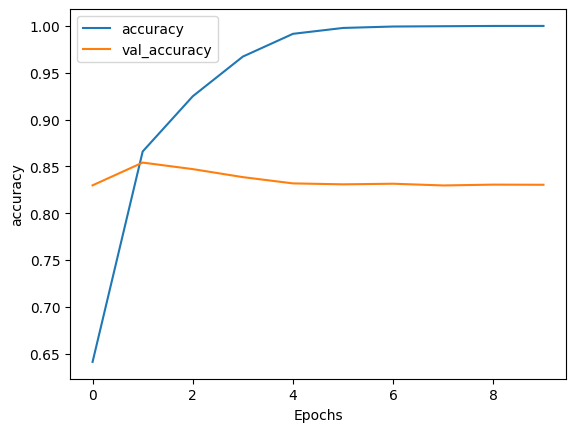

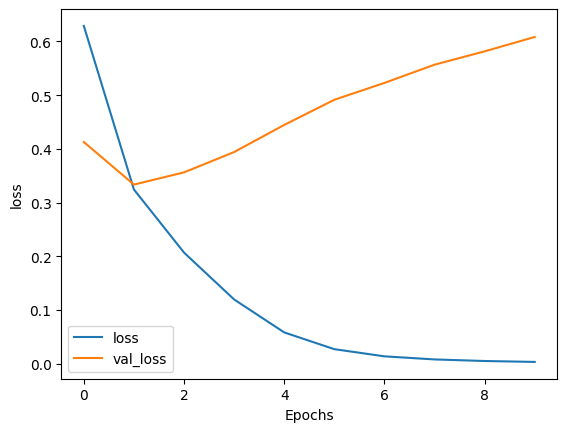

In [9]:
# Plot the accuracy and loss history
plot_graphs(history_flatten, 'accuracy')
plot_graphs(history_flatten, 'loss')

## LSTM

Next, you will use an LSTM. This is slower to train but useful in applications where the order of the tokens is important.

In [10]:
# Parameters
embedding_dim = 16
lstm_dim = 32
dense_dim = 6

# Model Definition with LSTM
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 120, 16)           160000    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               12544     
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 6)                 390       
                                                                 
 dense_3 (Dense)             (None, 1)                 7         
                                                                 
Total params: 172,941
Trainable params: 172,941
Non-trainable params: 0
_________________________________________________________________


In [11]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
history_lstm = model_lstm.fit(padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
196/196 [==============================] - 11s 50ms/step - loss: 0.5599 - accuracy: 0.6958 - val_loss: 0.3873 - val_accuracy: 0.8370
Epoch 2/10
196/196 [==============================] - 9s 48ms/step - loss: 0.3240 - accuracy: 0.8662 - val_loss: 0.3500 - val_accuracy: 0.8471
Epoch 3/10
196/196 [==============================] - 9s 47ms/step - loss: 0.2571 - accuracy: 0.9008 - val_loss: 0.3703 - val_accuracy: 0.8392
Epoch 4/10
196/196 [==============================] - 9s 47ms/step - loss: 0.2172 - accuracy: 0.9194 - val_loss: 0.3851 - val_accuracy: 0.8342
Epoch 5/10
196/196 [==============================] - 9s 47ms/step - loss: 0.1875 - accuracy: 0.9327 - val_loss: 0.4386 - val_accuracy: 0.8277
Epoch 6/10
196/196 [==============================] - 10s 49ms/step - loss: 0.1615 - accuracy: 0.9450 - val_loss: 0.5016 - val_accuracy: 0.8221
Epoch 7/10
196/196 [==============================] - 11s 56ms/step - loss: 0.1307 - accuracy: 0.9584 - val_loss: 0.5388 - val_accuracy: 0.8

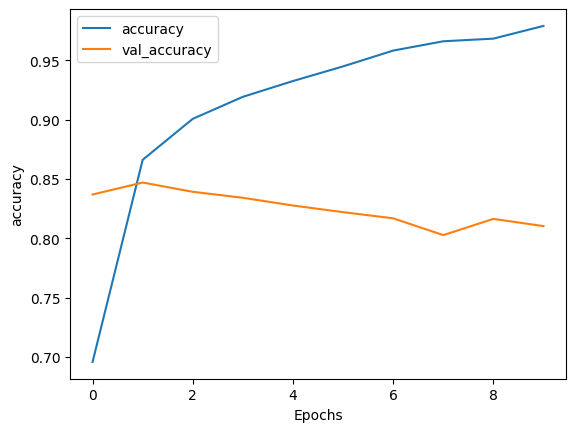

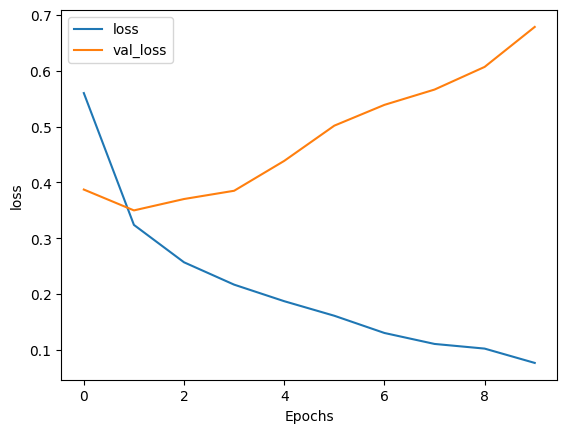

In [12]:
# Plot the accuracy and loss history
plot_graphs(history_lstm, 'accuracy')
plot_graphs(history_lstm, 'loss')

## GRU

The *Gated Recurrent Unit* or [GRU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU) is usually referred to as a simpler version of the LSTM. It can be used in applications where the sequence is important but you want faster results and can sacrifice some accuracy. You will notice in the model summary that it is a bit smaller than the LSTM and it also trains faster by a few seconds.

In [13]:
import tensorflow as tf

# Parameters
embedding_dim = 16
gru_dim = 32
dense_dim = 6

# Model Definition with GRU
model_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(gru_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_gru.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 120, 16)           160000    
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               9600      
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 6)                 390       
                                                                 
 dense_5 (Dense)             (None, 1)                 7         
                                                                 
Total params: 169,997
Trainable params: 169,997
Non-trainable params: 0
_________________________________________________________________


In [14]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
history_gru = model_gru.fit(padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
196/196 [==============================] - 14s 58ms/step - loss: 0.6004 - accuracy: 0.6448 - val_loss: 0.3966 - val_accuracy: 0.8243
Epoch 2/10
196/196 [==============================] - 11s 55ms/step - loss: 0.3258 - accuracy: 0.8662 - val_loss: 0.3452 - val_accuracy: 0.8517
Epoch 3/10
196/196 [==============================] - 11s 54ms/step - loss: 0.2517 - accuracy: 0.9032 - val_loss: 0.3776 - val_accuracy: 0.8352
Epoch 4/10
196/196 [==============================] - 11s 56ms/step - loss: 0.2021 - accuracy: 0.9278 - val_loss: 0.3930 - val_accuracy: 0.8370
Epoch 5/10
196/196 [==============================] - 11s 58ms/step - loss: 0.1676 - accuracy: 0.9418 - val_loss: 0.4606 - val_accuracy: 0.8274
Epoch 6/10
196/196 [==============================] - 11s 56ms/step - loss: 0.1337 - accuracy: 0.9551 - val_loss: 0.4879 - val_accuracy: 0.8260
Epoch 7/10
196/196 [==============================] - 11s 56ms/step - loss: 0.1050 - accuracy: 0.9663 - val_loss: 0.5873 - val_accuracy:

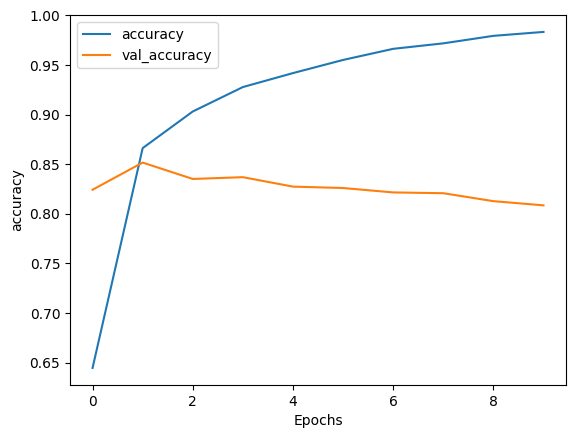

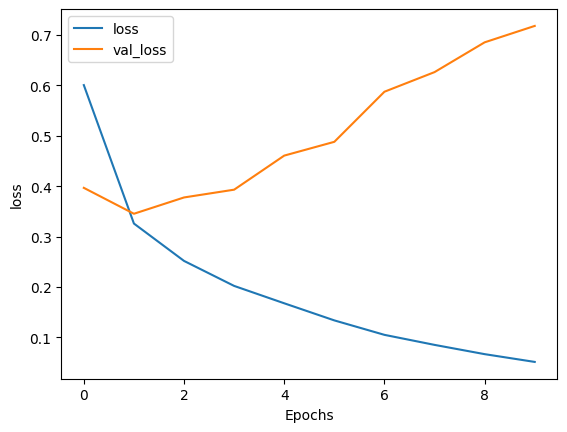

In [15]:
# Plot the accuracy and loss history
plot_graphs(history_gru, 'accuracy')
plot_graphs(history_gru, 'loss')

## Convolution

Lastly, you will use a convolution layer to extract features from your dataset. You will append a [GlobalAveragePooling1d](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling1D) layer to reduce the results before passing it on to the dense layers. Like the model with `Flatten`, this also trains much faster than the ones using RNN layers like `LSTM` and `GRU`.

In [16]:
# Parameters
embedding_dim = 16
filters = 128
kernel_size = 5
dense_dim = 6

# Model Definition with Conv1D
model_conv = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(filters, kernel_size, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_conv.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_conv.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 120, 16)           160000    
                                                                 
 conv1d (Conv1D)             (None, 116, 128)          10368     
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_6 (Dense)             (None, 6)                 774       
                                                                 
 dense_7 (Dense)             (None, 1)                 7         
                                                                 
Total params: 171,149
Trainable params: 171,149
Non-trainable params: 0
________________________________________________

In [17]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
history_conv = model_conv.fit(padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
196/196 [==============================] - 3s 14ms/step - loss: 0.5356 - accuracy: 0.7253 - val_loss: 0.3559 - val_accuracy: 0.8492
Epoch 2/10
196/196 [==============================] - 3s 15ms/step - loss: 0.3038 - accuracy: 0.8756 - val_loss: 0.3480 - val_accuracy: 0.8524
Epoch 3/10
196/196 [==============================] - 3s 15ms/step - loss: 0.2430 - accuracy: 0.9035 - val_loss: 0.3687 - val_accuracy: 0.8429
Epoch 4/10
196/196 [==============================] - 3s 14ms/step - loss: 0.2087 - accuracy: 0.9203 - val_loss: 0.4009 - val_accuracy: 0.8368
Epoch 5/10
196/196 [==============================] - 3s 13ms/step - loss: 0.1817 - accuracy: 0.9350 - val_loss: 0.4403 - val_accuracy: 0.8300
Epoch 6/10
196/196 [==============================] - 3s 15ms/step - loss: 0.1606 - accuracy: 0.9427 - val_loss: 0.4916 - val_accuracy: 0.8254
Epoch 7/10
196/196 [==============================] - 3s 13ms/step - loss: 0.1425 - accuracy: 0.9504 - val_loss: 0.5332 - val_accuracy: 0.8202

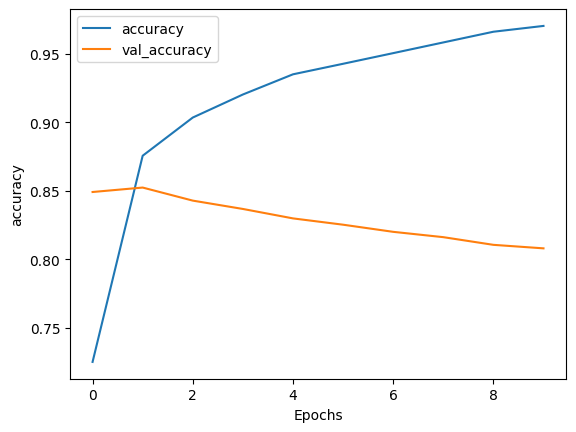

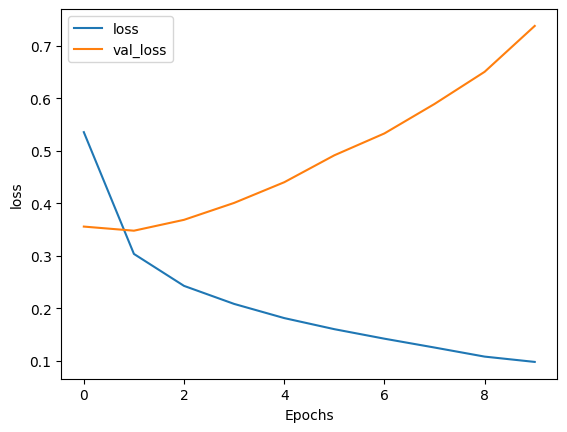

In [18]:
# Plot the accuracy and loss history
plot_graphs(history_conv, 'accuracy')
plot_graphs(history_conv, 'loss')

## Wrap Up

Now that you've seen the results for each model, can you make a recommendation on what works best for this dataset? Do you still get the same results if you tweak some hyperparameters like the vocabulary size? Try tweaking some of the values some more so you can get more insight on what model performs best.

In [34]:
predict = ["They obviously believe in the 'quantity vs. Quality' business theory, and seem quite content to continue pumping out these mediocre entries in the Marvel, Star Wars, and Pixar brands, until their formerly dedicated audiences finally cry 'enough!', and just...walk away, shaking their collective heads at how sad it was, the day The Mouse bought the rights to these storied franchises. My only remaining hope is that they'll pump the breaks and not try to oversaturate us with the two best remaining storylines - those being the wonderfully heart-filled Ant Man and Spider-Man series, which are the only ones (so far) they haven't managed to ruin.",
          "I always had some issues with MCU films but now they aren't even entertaining? Oh Raimi, what a disappointment. I honestly only liked the horror elements and being able to see some blood in a MCU film. Nothing else. The plot is super weak - the worst of the film - but the script is also very erroneous with some strange and unexplainable writing decisions. There are some interesting shots - some Dutch angles and POV are cool - but this feel stupidly long for a film that is just 2 hours long. It's like watching the action going from setpiece to setpiece in a very inorganic way while travelling between boring universe with a lot of cringe dialogue. I don't even get the point of all this story for the entire universe and even the score - surprisingly considering that is Elfman - is super generic. I won't lie: I had much more fun watching Eternals, Captain Marvel or Wonder Woman 1984 than this one. Said it.",
          "Richard Burton wasted his talents on alcohol. Let's hope Benedict Cumberbatch doesn't waste his talent on Marvel. What does it take, time wise, for him to make one of these derivative, adolescent wastes of cinematic energy? How many real films might he make, how many plays might he contribute to, were he not involved in this childish pablum?",
          "I'm a huge marvel fanboy, and hardly ever have anything bad to say to about the MCU, but this was a huge letdown. Ragnarok is easily one of my top 5 marvel films , so was very excited to see this one, but this was really really bad. It was boring as hell and none of the jokes landed for me. First time in a marvel movie I really wanted to leave or wished it would end already. Huge waste of Gorr the god butcher. And the whole Zeus and Olympus part were so cringe worthy. I don't know how this got made. It was garbage.",
           "I sometimes feel like Taika Waititi is wasting his talents making MCU movies when he could be making great original content. But then he does make pretty good MCU movies, so maybe it would be a shame to miss out on those. 'Thor: Love and Thunder' wasn't quite as good as 'Thor: Ragnarok' for me, but it was still a decent watch.The film is once again very light-hearted. It is certainly going for laughs more than anything else. Consequently the tone is very safe and no one ever feels like they are in much genuine danger. Which is a shame because Christian Bale plays a particularly menacing (at least visually) villain. There are some fun cameos along the way as usual. The film is pretty well paced too. It doesn't really have a period which I would say dragged. If you enjoyed 'Ragnarok' then you are almost certainly going to have a good time with this one. 7/10.",
          ]

predict_sequences = tokenizer.texts_to_sequences(predict) 
predict_padded = pad_sequences(predict_sequences, maxlen=max_length, truncating=trunc_type)

predict_prob = model_conv.predict(predict_padded)

for prob in predict_prob:
    print(f'good review - prob = {prob[0]:.5f}' if prob > 0.5 else f'bad review - prob = {prob[0]:.5f}')        


good review - prob = 0.98974
bad review - prob = 0.00000
bad review - prob = 0.00000
bad review - prob = 0.00000
bad review - prob = 0.00821


In [24]:
for i in range(6):
    print(training_sentences[i])
    print(training_labels[i])

This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.
0
I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development was co